# Train Model

This notebook contains functions for preprocessing and training models that weight the climate models from the NASA Earth Exchange Global Daily Downscaled Projections (NEX-GDDP-CMIP6) to match the temperature from from Oikolab, a provider of weather and climate datasets. 

The single most successful model is an elastic-net model based on rolling data with a 30-day window. This model yields an r2 value of 0.91 for the train dataframe and 0.89 for the test dataframe, outperforming the rolling baseline at 0.77 for the train dataframe and 0.75 for the test dataframe. However, there is variability at the coordinate level. The most variable coordinates appear over the Appalachian Mountains, on the border between Virginia and West Virginia, suggesting that an elevation feature might improve model performance.

## Import Packages

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import shap
from pathlib import Path
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

## Define Variables

In [2]:
WINDOW = 30
RANDOM_STATE = 42

In [3]:
# Load train dataframe
df_train = pd.read_parquet('../data/processed/df_easternmountain_train.parquet.gzip')
df_train['time'] = pd.to_datetime(df_train['time'])

# Load validate dataframe
df_validate = pd.read_parquet('../data/processed/df_easternmountain_validate.parquet.gzip')
df_validate['time'] = pd.to_datetime(df_validate['time'])

# Load test dataframe
df_test = pd.read_parquet('../data/processed/df_easternmountain_test.parquet.gzip')
df_test['time'] = pd.to_datetime(df_test['time'])

# Load project dataframe
df_project = pd.read_parquet('../data/processed/df_easternmountain_project.parquet.gzip')
df_project['time'] = pd.to_datetime(df_project['time'])

# Load history dataframe
df_actuals = pd.read_parquet('../data/processed/df_easternmountain_weather.parquet.gzip')
df_actuals['time'] = pd.to_datetime(df_actuals['time'])
df_actuals = df_actuals[(df_actuals['lat'].isin(df_train['lat'])) & (df_actuals['lon'].isin(df_train['lon']))]

## Define Functions

In [4]:
def preprocess_data(df_train, df_validate, augment=False, rolling=False, window=30):
    """
    Preprocess the training and validation dataframes.

    Parameters:
    - df_train (pd.DataFrame): DataFrame containing the training data.
    - df_validate (pd.DataFrame): DataFrame containing the validation data.
    - augment (bool): Boolean flag to indicate whether data augmentation should be applied.
    - rolling (bool): Boolean flag to indicate whether a rolling window transformation should be applied.
    - window (int): The size of the rolling window (in days).

    Returns:
    - A tuple of pd.DataFrames.
    """
    # Create a copy of the DataFrames to avoid modifying the originals
    df_train_processed = df_train.copy()
    df_validate_processed = df_validate.copy()

    if rolling:
        # Apply rolling window to the training data
        df_train_processed = to_rolling(df_train_processed, window=window)

        # Concatenate training and validation dataframes and apply rolling window
        df_concat = pd.concat([df_train, df_validate]).reset_index(drop=True)
        df_concat = df_concat[df_concat['time'] > pd.to_datetime(df_train['time'].max()) - pd.Timedelta(days=window)]
        df_validate_processed = to_rolling(df_concat, window=window)

    if augment:
        # Add a 'month' column based on the 'time' column to both dataframes
        df_train_processed.insert(3, 'month', df_train_processed['time'].dt.month)
        df_validate_processed.insert(3, 'month', df_validate_processed['time'].dt.month)

    # Return the processed dataframes
    return df_train_processed, df_validate_processed


In [5]:
def to_rolling(df, window=30, function='min'):
    """
    Converts the data in a given DataFrame to a rolling mean for each coordinate separately,
    with a specified window size. The function groups data by latitude and longitude coordinates,
    sorts by time within each group, and then applies a rolling mean operation. It returns a
    DataFrame and preserves the original order of columns.

    Parameters:
    - df (pd.DataFrame): The input DataFrame to be processed. It must contain 'lat' (latitude),
      'lon' (longitude), and 'time' columns. 'lat' and 'lon' are used for grouping and 'time' for
      sorting within each group and performing rolling operations.
    - window (int): The window size for the rolling mean calculation, with a default of 90.

    Returns:
    - pd.DataFrame: A DataFrame after applying a rolling mean operation on the data for each
      coordinate, dropping rows with NA values.
    """
    # Ensure 'time' column is in datetime format
    df['time'] = pd.to_datetime(df['time'])

    # Sort the DataFrame by 'time' to ensure correct rolling window application
    df.sort_values(by=['lat', 'lon', 'time'], inplace=True)

    # Forward fill missing values
    df.ffill(inplace=True)
    
    # Group by 'lat' and 'lon', then apply rolling mean within each group
    df_rolling = df.groupby(['lat', 'lon'], as_index=False).rolling(window, on='time').agg(function)
    df_rolling = df_rolling.dropna().reset_index(drop=True)
    
    return df_rolling


In [6]:
def get_arrays(df, target=True):
    """
    Extracts features, target variable, spatial coordinates, and dates from a DataFrame.
    
    This function modifies a copy of the input DataFrame, extracting columns for spatial coordinates ('lat', 'lon'),
    dates ('time'), and the target variable ('fahrenheit'). The remaining columns are considered feature variables.

    Parameters:
    - df (pd.DataFrame): The input DataFrame from which to extract the data. The DataFrame should contain columns for
      latitude ('lat'), longitude ('lon'), time ('time'), various model scenarios, and a target variable ('fahrenheit').
    
    Returns:
    - tuple: A tuple containing the extracted data in the following order:
        - X (pd.DataFrame): A DataFrame of the feature variables, represented by the remaining model scenario columns
          after 'lat', 'lon', 'time', and 'fahrenheit' have been removed.
        - y (pd.Series): The target variable, extracted from the 'fahrenheit' column.
        - time (pd.Series): The date values, extracted from the 'time' column.
        - features (pd.Index): The names of the columns that are considered feature variables.
    """
    # Create a copy of the DataFrame to avoid modifying the original
    df = df.copy()
    
    # Extract columns from the DataFrame using the pop method
    time = df.pop('time')
    if target:
        y = df.pop('fahrenheit')
    else:
        y = None

    # The remaining DataFrame now consists only of the feature variables
    X = df
    features = X.columns

    return X, y, time, features


In [7]:
def train_single_model(df_train, df_validate, model):
    """
    Train a machine learning model using the provided training and validation dataframes.

    This function preprocesses the input dataframes to extract feature arrays and labels,
    scales the features using standard scaling, fits the model on the scaled training data,
    and then evaluates it using both the training and validation data. It calculates the
    root mean squared error (RMSE) and the R-squared (R2) value for both datasets.

    Parameters:
    - df_train: A pandas DataFrame containing the training data.
    - df_validate: A pandas DataFrame containing the validation data.
    - model: A scikit-learn compatible model that implements the .fit() and .predict() methods.

    Returns:
    - model: The trained machine learning model.
    - results: A dictionary containing the RMSE and R2 scores for the training and validation sets.
    """
    # Extract features and labels from training and validation data
    X_train, y_train, _, _ = get_arrays(df_train)
    X_validate, y_validate, _, _ = get_arrays(df_validate)

    # Scale features to have mean=0 and variance=1
    scaler = StandardScaler().fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_validate_scaled = scaler.transform(X_validate)

    # Fit the model to the scaled training data
    model = model.fit(X_train_scaled, y_train)

    # Predict on the scaled training and validation data
    preds_train = model.predict(X_train_scaled)
    preds_validate = model.predict(X_validate_scaled)

    # Calculate performance metrics
    results = {
        'rmse_train': round(mean_squared_error(y_train, preds_train) ** 0.5, 2),
        'r2_train': round(r2_score(y_train, preds_train), 2),
        'rmse_validate': round(mean_squared_error(y_validate, preds_validate) ** 0.5, 2),
        'r2_validate': round(r2_score(y_validate, preds_validate), 2)
    }

    return model, results, scaler


In [8]:
def train_multiple_models(df_train, df_validate, model):
    """
    Trains a specified machine learning model for each unique latitude and longitude pair 
    found in the training data.

    Parameters:
    - df_train (pd.DataFrame): DataFrame containing the training data, expected to include 
      'lat' and 'lon' columns for latitude and longitude, respectively.
    - df_validate (pd.DataFrame): DataFrame containing the validation data, also expected 
      to include 'lat' and 'lon' columns.
    - model (Any): An instance of a machine learning model that supports the fit and predict 
      methods. This model will be trained on the data for each latitude and longitude pair.

    Returns:
    - models (list): A list of trained machine learning model instances, one for each unique 
      latitude and longitude pair.
    - df_results (pd.DataFrame): A DataFrame containing the latitude and longitude of each 
      location, along with the corresponding training and validation RMSE (Root Mean Squared Error) 
      and R2 (coefficient of determination) metrics.
    """
    # Extract coordinates from training data
    coords = df_train[['lat', 'lon']]

    # Remove duplicate
    coords = coords.drop_duplicates()
    lats = coords['lat'].to_list()
    lons = coords['lon'].to_list()

    models = []
    results = {}

    for lat, lon in zip(lats, lons):

        metrics = {}

        # Filter dataframes for the current coordinates
        df_train_filtered = df_train[(df_train['lat'] == lat) & (df_train['lon'] == lon)]
        df_validate_filtered = df_validate[(df_validate['lat'] == lat) & (df_validate['lon'] == lon)]

        # Extract arrays for model training and validation
        X_train, y_train, _, _ = get_arrays(df_train_filtered)
        X_validate, y_validate, _, _ = get_arrays(df_validate_filtered)
            
        # Fit the model and predict
        model.fit(X_train, y_train)
        preds_train = model.predict(X_train)
        preds_validate = model.predict(X_validate)

        # Calculate performance metrics
        metrics = {
            'rmse_train': round(mean_squared_error(y_train, preds_train) ** 0.5, 2),
            'r2_train': round(r2_score(y_train, preds_train), 2),
            'rmse_validate': round(mean_squared_error(y_validate, preds_validate) ** 0.5, 2),
            'r2_validate': round(r2_score(y_validate, preds_validate), 2)
        }

        models.append(model)
        results[(lat, lon)] = metrics

    # Convert results to DataFrame
    df_results = pd.DataFrame(results).transpose().reset_index()
    df_results = df_results.rename(columns={'level_0': 'lat', 'level_1': 'lon'})

    return models, df_results


In [9]:
def plot_spatial_results(df, lat='lat', lon='lon', value='rmse'):
    """
    Plots geographic results on a scatter map using Plotly Express.

    This function creates a scatter geo plot of the given DataFrame. It maps 'lat' and 'lon'
    as coordinates, and uses 'rmse' for both color and size scaling of the points.

    Parameters:
    - df (pd.DataFrame): A pandas DataFrame containing the columns 'lat', 'lon', and 'rmse'.

    Returns:
    - None
    """
    fig = px.scatter_geo(
        df,
        lat=lat,
        lon=lon,
        color=value,
        size=value,
        size_max=15,
        projection='albers usa',
        fitbounds='locations'
    )

    fig.update_layout(dragmode=False)

    fig.show()


In [10]:
def plot_temporal_results(df, model, scaler):
    """
    Plots average temporal predictions along with actual values on a line graph.

    Parameters:
    - df (pd.DataFrame): DataFrame containing the features and actual values.
    - model (Any): Trained model used to make predictions.
    - scaler (Any): Pre-fitted scaler used for transforming the features.

    Returns:
    None
    """
    # Create a copy of the DataFrame to avoid modifying the original data
    df = df.copy()

    # Extract and scale features
    X, _, _, _ = get_arrays(df)
    X_scaled = scaler.transform(X)

    # Add predictions to the DataFrame
    df['preds'] = model.predict(X_scaled)

    # Compute the average of actual and predicted values
    results = df.groupby('time')[['fahrenheit', 'preds']].mean().reset_index()

    # Plot the results using a line graph
    fig = px.line(results, x='time', y=['fahrenheit', 'preds'])
    fig.show()


In [11]:
def get_minimum(df, frequency='YE'):
    """
    Computes the minimum values of a DataFrame grouped by latitude and longitude over a specified time frequency.
    The 'time' column of the DataFrame is converted to datetime format and set as the index for resampling.

    Parameters:
    - df (pandas.DataFrame): The DataFrame containing at least 'time', 'lat', and 'lon' columns.
    - freq (str): Resampling frequency. Defaults to 'YE' (year end).

    Returns:
    - pandas.DataFrame: A DataFrame with minimum values for each group of 'lat' and 'lon' over the specified frequency.
    """
    # Create a copy of the DataFrame to avoid modifying the original
    df = df.copy()

    # Ensure 'time' column is in datetime format and set as index
    df['time'] = pd.to_datetime(df['time'])
    df.set_index('time', inplace=True)

    # Group by 'lat' and 'lon', resample according to the given frequency, and calculate minimum
    return df.groupby(['lat', 'lon']).resample(frequency, include_groups=False).min().reset_index()


In [12]:
def get_zone(df, frequency='YE', window=30):
    """
    Categorizes temperature values in a DataFrame into discrete zones based on the 'temp' column.

    This function assigns a zone number to each temperature value in the DataFrame.
    The zones are defined by temperature ranges spanning 5 degrees each, from -60 to 65 degrees.
    Each zone is labeled with integers from 1 to 13.

    Parameters:
    - df (pd.DataFrame): DataFrame containing a 'temp' column with temperature values.
    - frequency (str): Resampling frequency for the minimum temperature calculation. Defaults to 'YE' (year end).
    - window(int): Window size for the rolling mean calculation. Defaults to 30.

    Returns:
    - pd.DataFrame: A modified DataFrame including a new column 'zone' with the categorized zone values.
    """
    # Define the bins for temperature categorization
    bins = range(-60, 70, 5)
    
    # Define the labels for each bin
    labels = np.linspace(1, 13, 25)

    # Calculate the rolling mean of minimum temperatures
    df_minimum = get_minimum(df, frequency)
    df_zone = to_rolling(df_minimum, window=window, function='mean')

    # Categorize temperatures into zones
    df_zone['zone'] = pd.cut(df_zone['temp'].round(), bins=bins, labels=labels)

    return df_zone


In [13]:
def save_dataframe(folderpath, filename, dataframe):
    """
    Saves a given dataframe to a Parquet file with GZIP compression in a specified
    directory and subdirectory ('processed').

    Parameters:
    - folderpath: str, the path to the main folder where the file will be saved.
    - filename: str, the name of the file to be saved.
    - dataframe: DataFrame, the pandas DataFrame to save.
    """    
    # Create a Path object for folder_path to ensure correct path manipulation
    folder = Path(folderpath)

    # Combine the folder path and file name to create the full path to the file
    filepath = folder / 'processed' / (filename + '.parquet.gzip')
    
    dataframe.to_parquet(filepath, compression='gzip')
    

## Explore Data

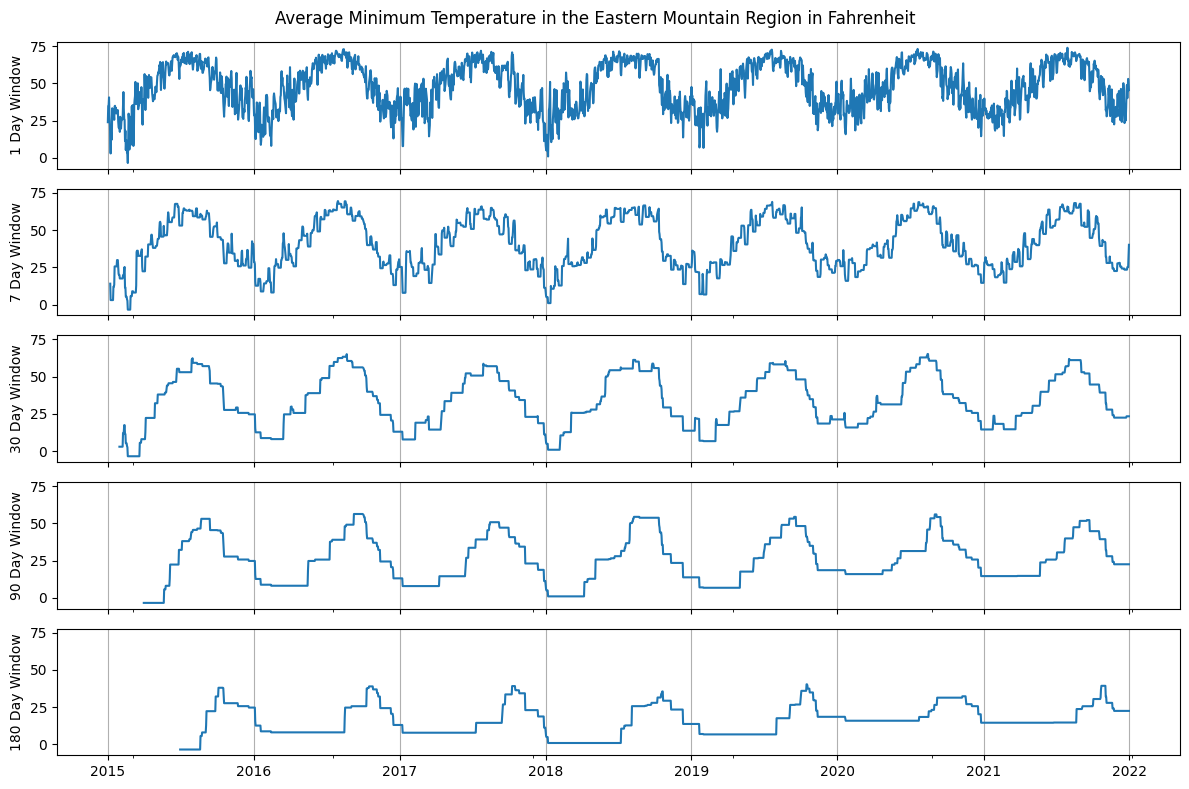

In [14]:
# Calculate the average minimum temperature for each time point
data = df_train.groupby('time').mean().iloc[:, -1].reset_index()
data['time'] = pd.to_datetime(data['time'])

windows = [1, 7, 30, 90, 180]

# Create subplots for each rolling window size
fig, axs = plt.subplots(
    nrows=len(windows), 
    ncols=1, 
    figsize=(12, 8), 
    sharex=True, 
    sharey=True, 
    tight_layout=True
)

# Plot the rolling average for each window size
for i, window in enumerate(windows):
    rolling_data = data.set_index('time').rolling(window).min()
    rolling_data.plot(ax=axs[i], legend=False)
    axs[i].set_xlabel('')
    axs[i].set_ylabel(f'{window} Day Window')
    axs[i].grid(visible=True, axis='x')

# Set the overall figure title
fig.suptitle('Average Minimum Temperature in the Eastern Mountain Region in Fahrenheit')

# Center-align the x-axis labels of the last subplot
axs[-1].tick_params(axis='x', rotation=0)  # Ensure labels are not rotated
for label in axs[-1].get_xticklabels():
    label.set_horizontalalignment('center')

plt.show()

fig.savefig('../reports/figures/rolling_average_easternmountain.png')

Several climate models are missing values for leap year dates (e.g. Febrary 29, 2024). In addition, KACE-1-0-G and UKESM1-0-L are missing values for dates roughly every two months, beginning on January 1, 2024. These missing values have been propagated using forward fill.

In [15]:
# Identify the columns with NaNs
na_count = df_project.isna().sum()
na_models = na_count[na_count > 0].index.to_list()

# Create a dictionary to store dates
na_dates = {}

# Iterate over each column with NaNs
for model in na_models:
    # Identify the dates with NaNs
    df_na = df_project[df_project[model].isna()].groupby(['time']).count()
    df_index = df_na.index.to_list()
    
    # Add the dates to the dictionary
    na_dates[model] = df_index

na_dates

{'CMCC-ESM2-ssp126': [Timestamp('2024-02-29 00:00:00'),
  Timestamp('2028-02-29 00:00:00'),
  Timestamp('2032-02-29 00:00:00'),
  Timestamp('2036-02-29 00:00:00'),
  Timestamp('2040-02-29 00:00:00'),
  Timestamp('2044-02-29 00:00:00'),
  Timestamp('2048-02-29 00:00:00')],
 'CMCC-ESM2-ssp245': [Timestamp('2024-02-29 00:00:00'),
  Timestamp('2028-02-29 00:00:00'),
  Timestamp('2032-02-29 00:00:00'),
  Timestamp('2036-02-29 00:00:00'),
  Timestamp('2040-02-29 00:00:00'),
  Timestamp('2044-02-29 00:00:00'),
  Timestamp('2048-02-29 00:00:00')],
 'CMCC-ESM2-ssp370': [Timestamp('2024-02-29 00:00:00'),
  Timestamp('2028-02-29 00:00:00'),
  Timestamp('2032-02-29 00:00:00'),
  Timestamp('2036-02-29 00:00:00'),
  Timestamp('2040-02-29 00:00:00'),
  Timestamp('2044-02-29 00:00:00'),
  Timestamp('2048-02-29 00:00:00')],
 'CMCC-ESM2-ssp585': [Timestamp('2024-02-29 00:00:00'),
  Timestamp('2028-02-29 00:00:00'),
  Timestamp('2032-02-29 00:00:00'),
  Timestamp('2036-02-29 00:00:00'),
  Timestamp('2040

## Train Model

### Establish Baseline

Averaging across the models yields an r2 value of 0.71 for the train dataframe and 0.73 for the validate dataframe.

In [16]:
# Process data
df_train_processed, df_validate_processed = preprocess_data(df_train, df_validate, rolling=True, window=1)
X_train, y_train, time_train, features_train = get_arrays(df_train_processed)
lat_train = X_train.pop('lat')
lon_train = X_train.pop('lon')
X_validate, y_validate, time_validate, features_validate = get_arrays(df_validate_processed)
lat_validate = X_validate.pop('lat')
lon_validate = X_validate.pop('lon')

# Average across models and scenarios
print('rmse_train:', round(mean_squared_error(y_train, X_train.mean(axis=1)) ** 0.5, 2))
print('r2_train:', round(r2_score(y_train, X_train.mean(axis=1)), 2))
print('rmse_validate:', round(mean_squared_error(y_validate, X_validate.mean(axis=1)) ** 0.5, 2))
print('r2_validate:', round(r2_score(y_validate, X_validate.mean(axis=1)), 2))

rmse_train: 8.51
r2_train: 0.71
rmse_validate: 8.6
r2_validate: 0.73


Averaging across the models with rolling yields an r2 value of 0.76 for the train dataframe and 0.84 for the validate dataframe.

In [17]:
# Process rolling data
df_train_processed, df_validate_processed = preprocess_data(df_train, df_validate, rolling=True, window=WINDOW)
X_train, y_train, time_train, features_train = get_arrays(df_train_processed)
lat_train = X_train.pop('lat')
lon_train = X_train.pop('lon')
X_validate, y_validate, time_validate, features_validate = get_arrays(df_validate_processed)
lat_validate = X_validate.pop('lat')
lon_validate = X_validate.pop('lon')

# Average across models and scenarios
print('rmse_train:', round(mean_squared_error(y_train, X_train.mean(axis=1)) ** 0.5, 2))
print('r2_train:', round(r2_score(y_train, X_train.mean(axis=1)), 2))
print('rmse_validate:', round(mean_squared_error(y_validate, X_validate.mean(axis=1)) ** 0.5, 2))
print('r2_validate:', round(r2_score(y_validate, X_validate.mean(axis=1)), 2))

rmse_train: 8.57
r2_train: 0.76
rmse_validate: 7.57
r2_validate: 0.84


### Ordinary Least Squares Regression

#### Single Model

Training a single ordinarly least squares model with rolling yields an r2 value of 0.94 for the train dataframe and 0.88 for the validate dataframe. This model is more successful than the rolling baseline, though it may overfit the train dataframe and underfit the validate dataframe. 

In [18]:
# Process data
df_train_processed, df_validate_processed = preprocess_data(df_train, df_validate, rolling=True, window=WINDOW)

# Instantiate a model
ols = LinearRegression()

# Train a single model and assess performance
_, results, _ = train_single_model(df_train_processed, df_validate_processed, ols) 
results

{'rmse_train': 4.33,
 'r2_train': 0.94,
 'rmse_validate': 6.5,
 'r2_validate': 0.88}

#### Multiple Models

Training multiple ordinarly least squares models with rolling yields an r2 value of 0.95 for the train dataframe and 0.86 for the validate dataframe. These models are more successful than the rolling baseline, though they may overfit the train dataframe and underfit the validate dataframe. 

In [19]:
# Process data
df_train_processed, df_validate_processed = preprocess_data(df_train, df_validate, rolling=True, window=WINDOW)

# Instantiate a model
ols = LinearRegression()

# Train a model for each coordinate and assess performance
_, results = train_multiple_models(df_train_processed, df_validate_processed, ols)
round(results.iloc[:, 2:].mean(), 2)

rmse_train       3.72
r2_train         0.95
rmse_validate    6.89
r2_validate      0.86
dtype: float64

### Elastic-Net Regression

#### Single Model

Training a single elastic-net model with rolling yields an r2 value of 0.92 for the train dataframe and 0.89 for the validate dataframe. This model outperforms the rolling baseline. It fits both the train dataframe and the validate dataframe. However, there is variability at the coordinate level, with r2 values ranging from 0.81 to 0.93 for the validate dataframe. The most variable coordinates appear over the Appalachian Mountains, on the border between Virginia and West Virginia.

In [20]:
# Process data
df_train_processed, df_validate_processed = preprocess_data(df_train, df_validate, rolling=True, window=WINDOW)

# Instantiate a model
eln = ElasticNet(alpha=1.0, max_iter=10000, positive=True, random_state=RANDOM_STATE)

# Train a single model and assess performance
model, results, scaler = train_single_model(df_train_processed, df_validate_processed, eln) 
results

{'rmse_train': 5.12,
 'r2_train': 0.92,
 'rmse_validate': 6.35,
 'r2_validate': 0.89}

In [21]:
# Assess temporal performance
df_train_processed, df_validate_processed = preprocess_data(df_train, df_validate, rolling=True, window=WINDOW)
plot_temporal_results(pd.concat([df_train_processed, df_validate_processed]), model, scaler)

In [22]:
# Get arrays
X_validate, _, _, features_validate = get_arrays(df_validate_processed)
X_validate_scaled = scaler.transform(X_validate)

# Add predictions to dataframe
df_validate_processed['preds'] = model.predict(X_validate_scaled)

# Assess spatial performance
single_model_results = df_validate_processed.groupby(
        ['lat', 'lon']
    ).apply(
        lambda x: pd.Series({
            'rmse': round(mean_squared_error(x['fahrenheit'], x['preds']) ** 0.5, 2),
            'r2': round(r2_score(x['fahrenheit'], x['preds']), 2)
        }), include_groups=False
    ).reset_index(
    ).sort_values('r2', ascending=False)

# Print results
print('rmse_min', single_model_results.rmse.min())
print('r2_min:', single_model_results.r2.min())
print('rmse_max:', single_model_results.rmse.max())
print('r2_max:', single_model_results.r2.max())

# Plot results
plot_spatial_results(single_model_results, lat='lat', lon='lon', value='rmse')

rmse_min 4.48
r2_min: 0.81
rmse_max: 9.37
r2_max: 0.93


#### Multiple Models

Training multiple elastic-net models with rolling yields an r2 value of 0.93 for the train dataframe and 0.89 for the validate dataframe. These models are more successful than the rolling baseline and marginally more successful than the single elastic-net model with rolling.

At the coordinate level, the multiple model approach yields r2 values between 0.83 and 0.94. Like the single model, the most variable regions appear to be in the Appalachian Mountains, on the border between Virginia and West Virginia.

In [23]:
# Process data
df_train_processed, df_validate_processed = preprocess_data(df_train, df_validate, rolling=True, window=WINDOW)

# Instantiate a model
eln = ElasticNet(alpha=1.0, max_iter=10000, positive=True, random_state=RANDOM_STATE)

# Train a model for each coordinate and assess performance
_, results = train_multiple_models(df_train_processed, df_validate_processed, eln)
round(results.iloc[:, 2:].mean(), 2)

rmse_train       4.48
r2_train         0.93
rmse_validate    5.99
r2_validate      0.89
dtype: float64

In [24]:
# Assess spatial performance
multiple_model_results = results.sort_values('r2_validate', ascending=False)

# Print results
print('r2_min:', round(multiple_model_results.r2_validate.min(), 2))
print('r2_max:', round(multiple_model_results.r2_validate.max(), 2))

# Plot results
plot_spatial_results(multiple_model_results, lat='lat', lon='lon', value='rmse_validate')

r2_min: 0.83
r2_max: 0.94


## Evaluate Model

### Evaluate Features

Roughly three quarters of the model-scenario combinations contribute to the predictive power of the elastic-net model. Coefficients range from 0.0 to just over 0.8 for UKESM1-0-L-SSP245. However, according to SHapley Additive exPlanations (SHAP), the most influential model-scenario combinations include CanESM5-SSP370, GFDL-ESM4-SSP585, and ACCESS-CM2-SSP126.

In [25]:
# Process data
df_train_processed, df_validate_processed = preprocess_data(df_train, df_validate, rolling=True, window=WINDOW)

# Instantiate a model
eln = ElasticNet(alpha=1.0, max_iter=10000, positive=True, random_state=RANDOM_STATE)

# Train a single model
model, _, scaler = train_single_model(df_train_processed, df_validate_processed, eln) 

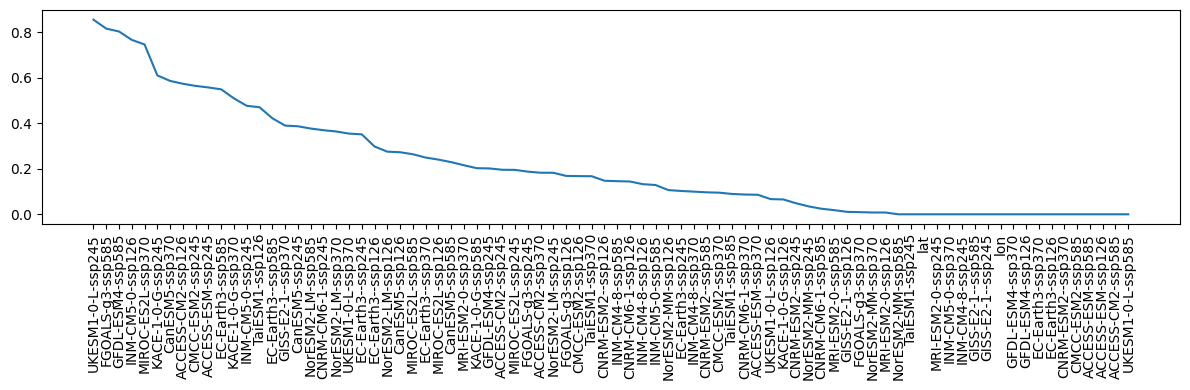

In [26]:
# Retrieve weights
X, _, _, features = get_arrays(df_train_processed)
coefs = pd.DataFrame(model.coef_, index=features_validate, columns=['coef']).sort_values('coef', ascending=False)

# Plot weights
fig, axs = plt.subplots(figsize=(12, 4))
axs.plot(coefs)
axs.tick_params(axis='x', rotation=90)
plt.tight_layout()
plt.show()

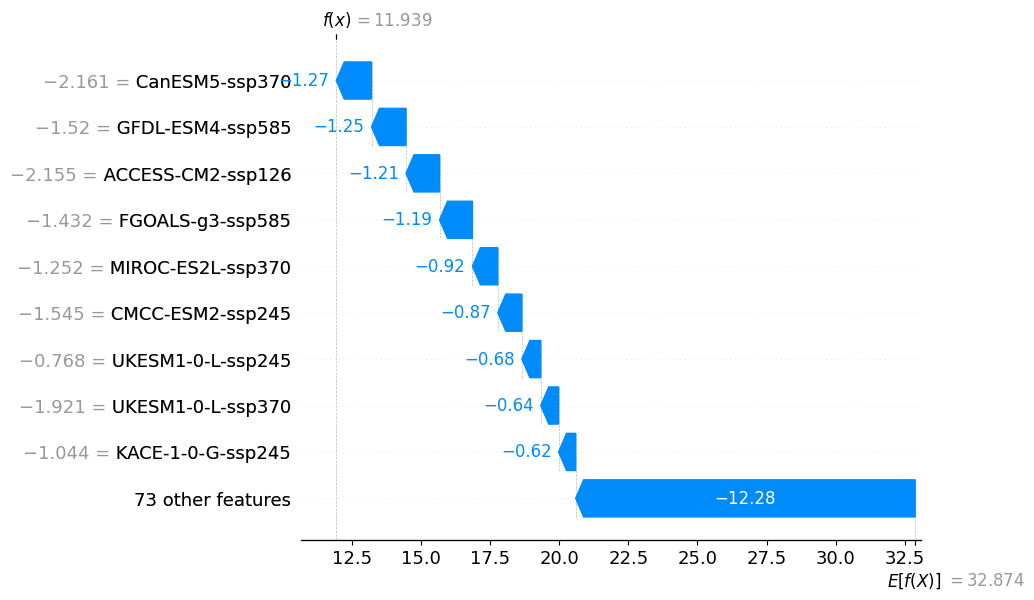

In [27]:
# Plot SHapley Additive exPlanations (SHAP)
X_scaled = scaler.transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=features)
explainer = shap.explainers.Linear(model, X_scaled)
shap_values = explainer(X_scaled)
shap.plots.waterfall(shap_values[0])

### Evaluate Final Model

In [28]:
# Process data
df_concat = pd.concat([df_train, df_validate]).reset_index(drop=True)
df_train_processed, df_test_processed = preprocess_data(df_concat, df_test, rolling=True, window=WINDOW)

# Instantiate a model
eln = ElasticNet(alpha=1.0, max_iter=10000, positive=True, random_state=RANDOM_STATE)

# Train a single model
model, results, scaler = train_single_model(df_train_processed, df_test_processed, eln)

Averaging across the models with rolling, combining the train and validate dataframes, yields an r2 value of 0.77 for the combined dataframe and 0.75 for the test dataframe.

In [29]:
# Get arrays
X_train, y_train, _, _ = get_arrays(df_train_processed)
X_test, y_test, _, _ = get_arrays(df_test_processed)

# Assess performance
print('rmse_train:', round(mean_squared_error(y_train, X_train.iloc[:, 2:].mean(axis=1)) ** 0.5, 2))
print('r2_train:', round(r2_score(y_train, X_train.iloc[:, 2:].mean(axis=1)), 2))
print('rmse_test:', round(mean_squared_error(y_test, X_test.iloc[:, 2:].mean(axis=1)) ** 0.5, 2))
print('r2_test:', round(r2_score(y_test, X_test.iloc[:, 2:].mean(axis=1)), 2))

rmse_train: 8.45
r2_train: 0.77
rmse_test: 8.34
r2_test: 0.75


Training a single elastic-net model with rolling yields an r2 value of 0.91 for the combined train and validate dataframe and 0.89 for the test dataframe. This model outperforms the updated rolling baseline.

In [30]:
results

{'rmse_train': 5.27,
 'r2_train': 0.91,
 'rmse_validate': 5.67,
 'r2_validate': 0.89}

## Predict Hardiness Zone

In [31]:
# Process data
_, df_project_processed = preprocess_data(df_test.iloc[:, :-1], df_project, rolling=True, window=WINDOW)

# Get arrays
X, _, time, _ = get_arrays(df_project_processed, target=False)

# Scale features
X_scaled = scaler.transform(X)

# Predict temperature
preds = model.predict(X_scaled)

# Add predictions to dataframe
df_predictions = df_project_processed.assign(preds=preds)
df_predictions = df_predictions[['lat', 'lon', 'time', 'preds']]

In [32]:
# Create a dataframe with actuals and predictions
df_actuals_predictions = pd.concat([df_actuals, df_predictions]).reset_index(drop=True)
df_actuals_predictions['temp'] = df_actuals_predictions['fahrenheit'].combine_first(df_actuals_predictions['preds'])
df_actuals_predictions = df_actuals_predictions[['lat', 'lon', 'time', 'temp']]

In [33]:
# Create a dataframe with USDA Plant Hardiness Zones
df_zone = get_zone(df_actuals_predictions)

In [42]:
df_zone.head(10)

,lat,lon,time,temp,zone
0,35.25,-83.25,2014-12-31,-1.424789,6.5
1,35.25,-83.25,2015-12-31,-0.684989,6.5
2,35.25,-83.25,2016-12-31,0.006812,6.5
3,35.25,-83.25,2017-12-31,0.164012,6.5
4,35.25,-83.25,2018-12-31,0.398612,6.5
5,35.25,-83.25,2019-12-31,1.071211,7.0
6,35.25,-83.25,2020-12-31,0.842011,7.0
7,35.25,-83.25,2021-12-31,1.645412,7.0
8,35.25,-83.25,2022-12-31,1.333535,7.0
9,35.25,-83.25,2023-12-31,1.934938,7.0


In [34]:
save_dataframe('../data', 'df_easternmountain_results', df_zone)